# Jolideco Analysis of Chandra Data of E0102

In [1]:
import os
os.environ['JOLIDECO_GMM_LIBRARY'] = '/Users/adonath/github/jolideco/jolideco-gmm-prior-library'

In [2]:
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib as mpl
from astropy.visualization import simple_norm
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.wcs import FITSFixedWarning
from jolideco.core import MAPDeconvolver, MAPDeconvolverResult
from jolideco.utils.numpy import split_datasets_validation
from jolideco.models import (
    SpatialFluxComponent,
    FluxComponents,
    NPredModels,
    NPredCalibration,
    NPredCalibrations
)
from jolideco.priors import GMMPatchPrior, GaussianMixtureModel
from jolideco.utils.norms import IdentityImageNorm, FixedMaxImageNorm
from itertools import zip_longest
from regions import CircleSkyRegion
from gammapy.maps import Maps, WcsGeom, Map

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FITSFixedWarning)

In [4]:
# for vscode dark theme
plt.style.use('dark_background')
mpl.rcParams['figure.facecolor'] = '#25292E'


In [34]:
if "snakemake" in globals():
    filenames = [Path(_) for _ in snakemake.input]
    filename_jolideco_result = Path(snakemake.output.filename_jolideco_result)
    filename_npred_stacked = Path(snakemake.output.filename_npred_stacked)
else:
    config_name = "e0102-broadband"
    PATH_BASE = Path(f"../../results/{config_name}/")
    filenames = (PATH_BASE / "input").glob("*.fits")
    filename_jolideco_result = PATH_BASE / "jolideco" / f"{config_name}-result-jolideco.fits"
    filename_npred_stacked = PATH_BASE / "jolideco" / "{config_name}-npred.fits"

In [6]:
filenames = list(Path("../../results/e0102-broadband/").glob("*/maps/*-counts.fits"))

In [7]:
datasets = {}

def read_dataset(filename_counts):
    """Read counts, exposure and psf maps."""
    filename_exposure = filename_counts.parent / filename_counts.name.replace("counts", "exposure")
    filename_psf = filename_counts.parent / filename_counts.name.replace("counts", "e0102-marx-psf")
    counts = Map.read(filename_counts)    

    psf = Map.read(filename_psf)
    psf = psf.cutout(psf.geom.center_skydir, width="10 arcsec")
    psf.data /= psf.data.sum()
    return {
        "counts": counts,
        "exposure": Map.read(filename_exposure),
        "psf": psf,
        "background": Map.from_geom(counts.geom) + 1e-2,
    }



for filename in filenames:
    obs_id = filename.parts[-3]
    datasets[f"obs-id-{obs_id}"] = read_dataset(filename)


## Counts

In [8]:
stacked = Map.from_geom(datasets["obs-id-1308"]["counts"].geom)

for name, dataset in datasets.items():
    stacked += dataset["counts"]

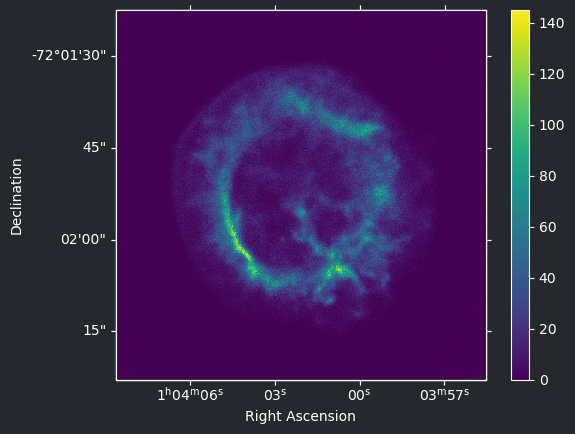

In [9]:
stacked.plot(cmap="viridis", add_cbar=True);

## PSF

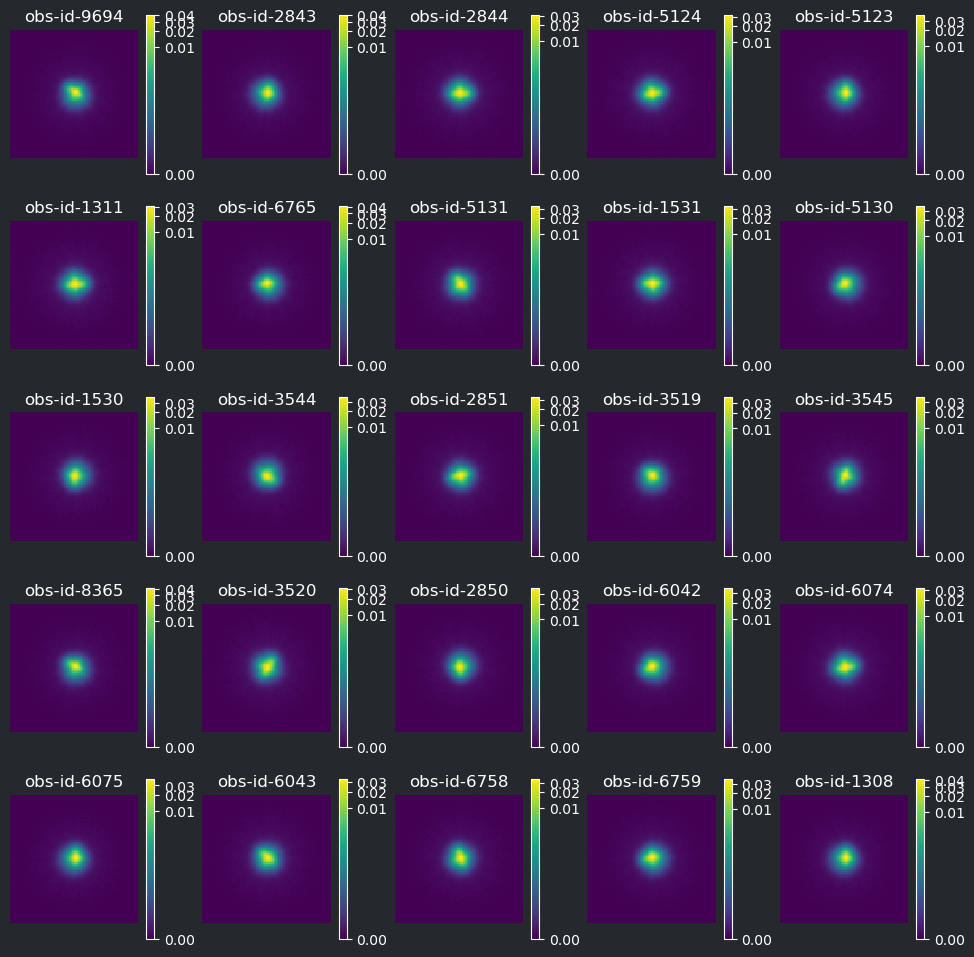

In [10]:
wcs = datasets["obs-id-1308"]["psf"].geom.wcs

fig, axes = plt.subplots(
    ncols=5,
    nrows=5,
    subplot_kw={"projection": wcs},
    figsize=(12, 12)
)

for ax, (name, dataset) in zip(axes.flat, datasets.items()):
    psf = dataset["psf"]
    psf.plot(ax=ax, cmap="viridis", add_cbar=True, stretch="log", vmin=0)
    ax.set_title(f"{name}")
    ax.axis("off")

plt.savefig("/Users/adonath/Desktop/psfs-e0102.png", dpi=300)

In [11]:
def to_jolideco_dataset(maps, dtype=np.float32):
    """Convert Gammapy maps to Jolideco dataset."""
    return {
        "counts": maps["counts"].data.astype(dtype),
        "background": maps["background"].data.astype(dtype),
        "psf": {"e0102": maps["psf"].data.astype(dtype)},
        "exposure": maps["exposure"].data.astype(dtype),
    }

In [12]:
datasets_jolideco = {name: to_jolideco_dataset(maps) for name, maps in datasets.items()}

## Run Jolideco

In [13]:
gmm = GaussianMixtureModel.from_registry("jwst-cas-a-v0.1")
gmm.meta.stride = 4
print(gmm)

GaussianMixtureModel
--------------------

  type                  : jwst-cas-a-v0.1



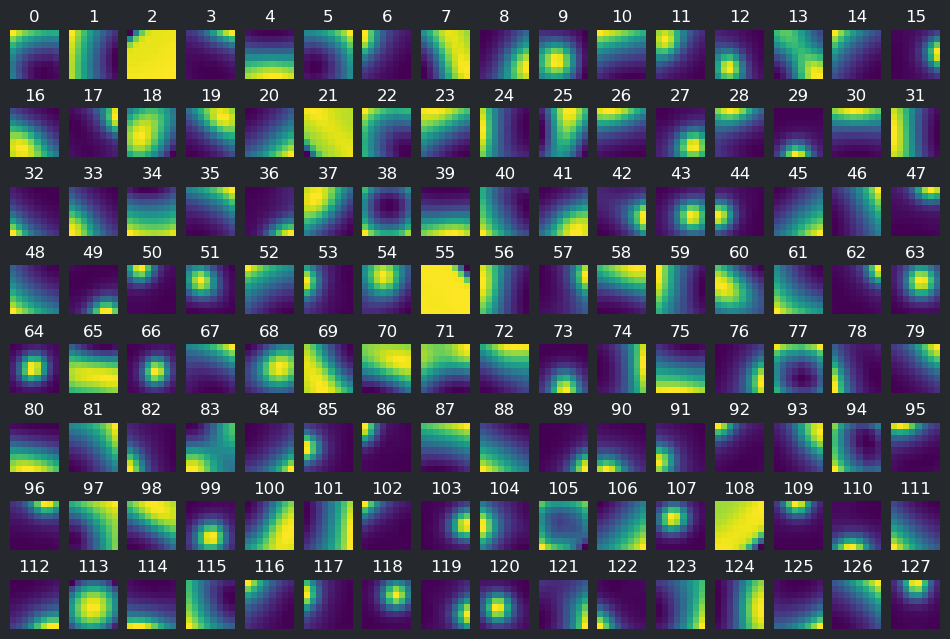

In [14]:
gmm.plot_mean_images(ncols=16, figsize=(12, 8))

In [15]:
patch_prior = GMMPatchPrior(
    gmm=gmm,
    cycle_spin=True,
    cycle_spin_subpix=True,
    norm=IdentityImageNorm()
)


shape = datasets_jolideco["obs-id-1308"]["counts"].shape
flux_init = np.random.normal(loc=3, scale=0.01, size=shape).astype(np.float32)

component = SpatialFluxComponent.from_numpy(
    flux=flux_init,
    prior=patch_prior,
    use_log_flux=True,
    upsampling_factor=2,
)


components = FluxComponents()
components["e0102"] = component

print(components)

FluxComponents
--------------

  e0102                 : 

    use_log_flux        : True
    upsampling_factor   : 2
    frozen              : False
    prior               : 

      type              : gmm-patches
      stride            : 4
      cycle_spin        : True
      cycle_spin_subpix : True
      jitter            : False
      gmm               : 

        type            : jwst-cas-a-v0.1

      norm              : 

        type            : identity

      patch_norm        : 

        type            : std-subtract-mean

      device            : cpu





In [16]:
calibrations = NPredCalibrations()

for name in datasets_jolideco:
    calibration = NPredCalibration(background_norm=1., frozen=False)
    calibrations[name] = calibration


calibrations["obs-id-1308"].shift_xy.requires_grad = False

print(calibrations)

NPredCalibrations
-----------------

  obs-id-9694           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-2843           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-2844           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-5124           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-5123           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-1311           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-6765        

In [17]:
deconvolve = MAPDeconvolver(n_epochs=250, learning_rate=0.1, beta=1.)
print(deconvolve)

MAPDeconvolver
--------------

  n_epochs              : 250
  beta                  : 1.000
  learning_rate         : 0.100
  compute_error         : False
  stop_early            : False
  stop_early_n_average  : 10
  device                : cpu



In [18]:
datasets_train = split_datasets_validation(datasets_jolideco, n_validation=0)

In [19]:
# result = deconvolve.run(
#     components=components,
#     calibrations=calibrations,
#     **datasets_train,
# )

In [20]:
result = MAPDeconvolverResult.read(filename_jolideco_result)

INFO:jolideco.utils.io.fits:Reading ../../results/e0102-broadband/e0102-broadband-result-jolideco.fits


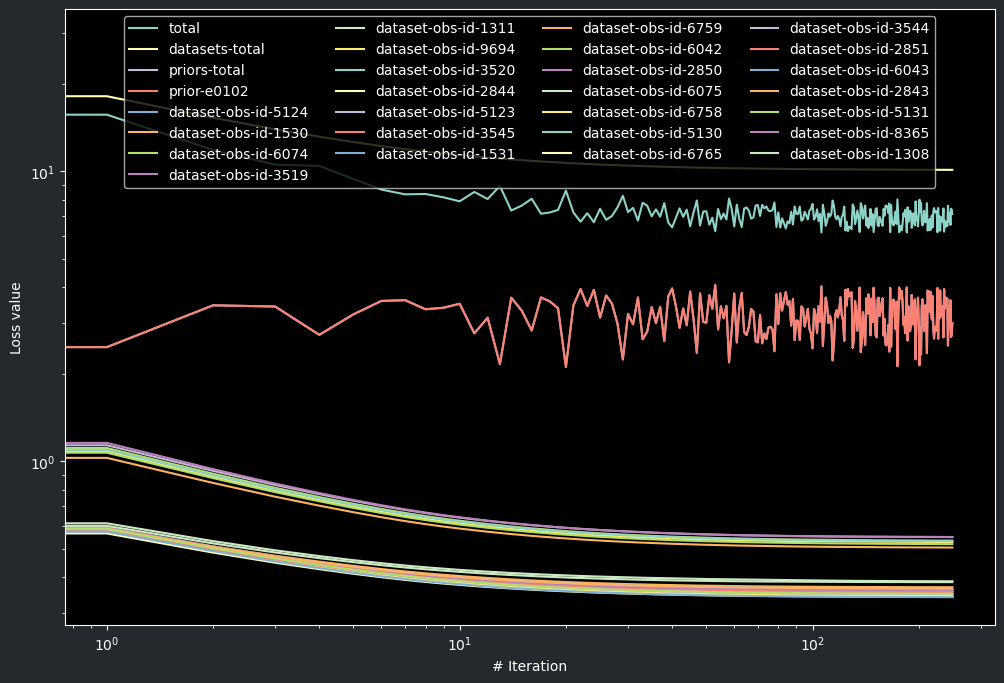

In [21]:
plt.figure(figsize=(12, 8))
result.plot_trace_loss()
plt.legend(loc="upper center", ncols=4)

## Results

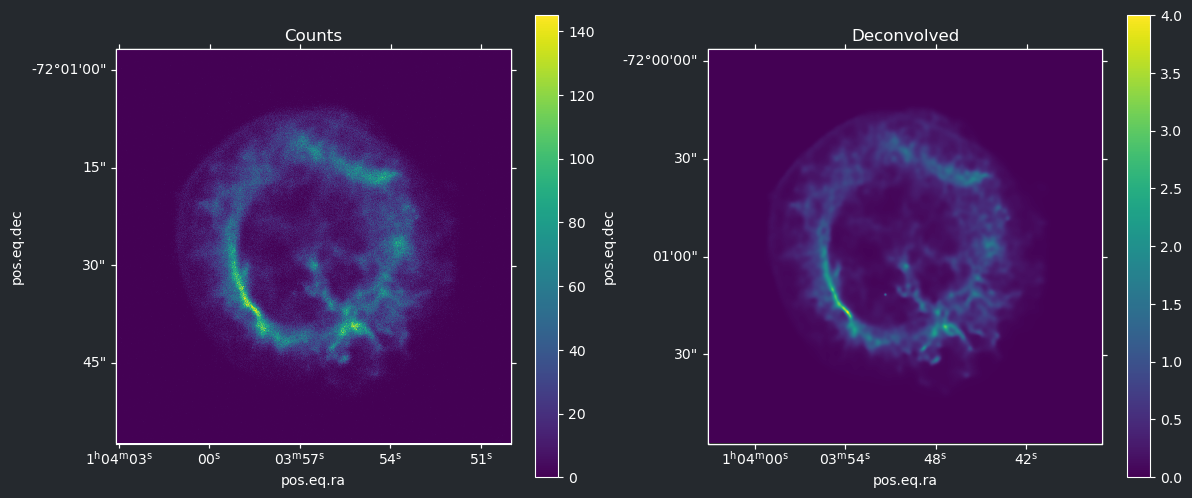

In [22]:
counts = np.sum([_["counts"] for _ in datasets_jolideco.values()], axis=0)

fig, axes = plt.subplots(
    ncols=2,
    subplot_kw={"projection": wcs},
    figsize=(14, 6)
)

norm_asinh = simple_norm(
    counts,
    min_cut=0,
    max_cut=4,
    stretch="power",
    power=1.,
    asinh_a=0.05
)



im = axes[0].imshow(counts, origin="lower", interpolation="None")
axes[0].set_title("Counts")
plt.colorbar(im);

im = axes[1].imshow(result.components.flux_upsampled_total_numpy, origin="lower", norm=norm_asinh, interpolation="gaussian")
axes[1].set_title("Deconvolved");
plt.colorbar(im);
plt.savefig("/Users/adonath/Desktop/deconvolved.png", dpi=300)


In [23]:
print(calibrations)

NPredCalibrations
-----------------

  obs-id-9694           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-2843           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-2844           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-5124           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-5123           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-1311           : 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.000
    frozen              : False

  obs-id-6765        

In [24]:
#result.write(filename_jolideco_result, overwrite=False)

## Residuals

In [26]:
geom = datasets["obs-id-1308"]["counts"].geom

In [27]:
npreds = {}

for name, dataset in datasets_jolideco.items():
    model = NPredModels.from_dataset_numpy(
        dataset=dataset,
        components=result.components,
    )
    
    fluxes = result.components.to_flux_tuple()
    npred = model.evaluate(fluxes=fluxes).detach().numpy()[0, 0]
    npreds[name] =  Map.from_geom(data=npred, geom=geom)
    

npreds_calibrated = {}

for name, dataset in datasets_jolideco.items():
    model = NPredModels.from_dataset_numpy(
        dataset=dataset,
        components=result.components,
        calibration=calibrations[name]
    )
    
    fluxes = result.components.to_flux_tuple()
    npred = model.evaluate(fluxes=fluxes).detach().numpy()[0, 0]
    npreds_calibrated[name] = Map.from_geom(data=npred, geom=geom)
    

/Users/adonath/software/mambaforge/envs/jolideco-fermi-examples/lib/python3.9/site-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [28]:
npred_stacked = Map.from_geom(geom=geom)

for npred in npreds_calibrated.values():
    npred_stacked.stack(npred)


npred_stacked.write(filename_npred_stacked, overwrite=True)

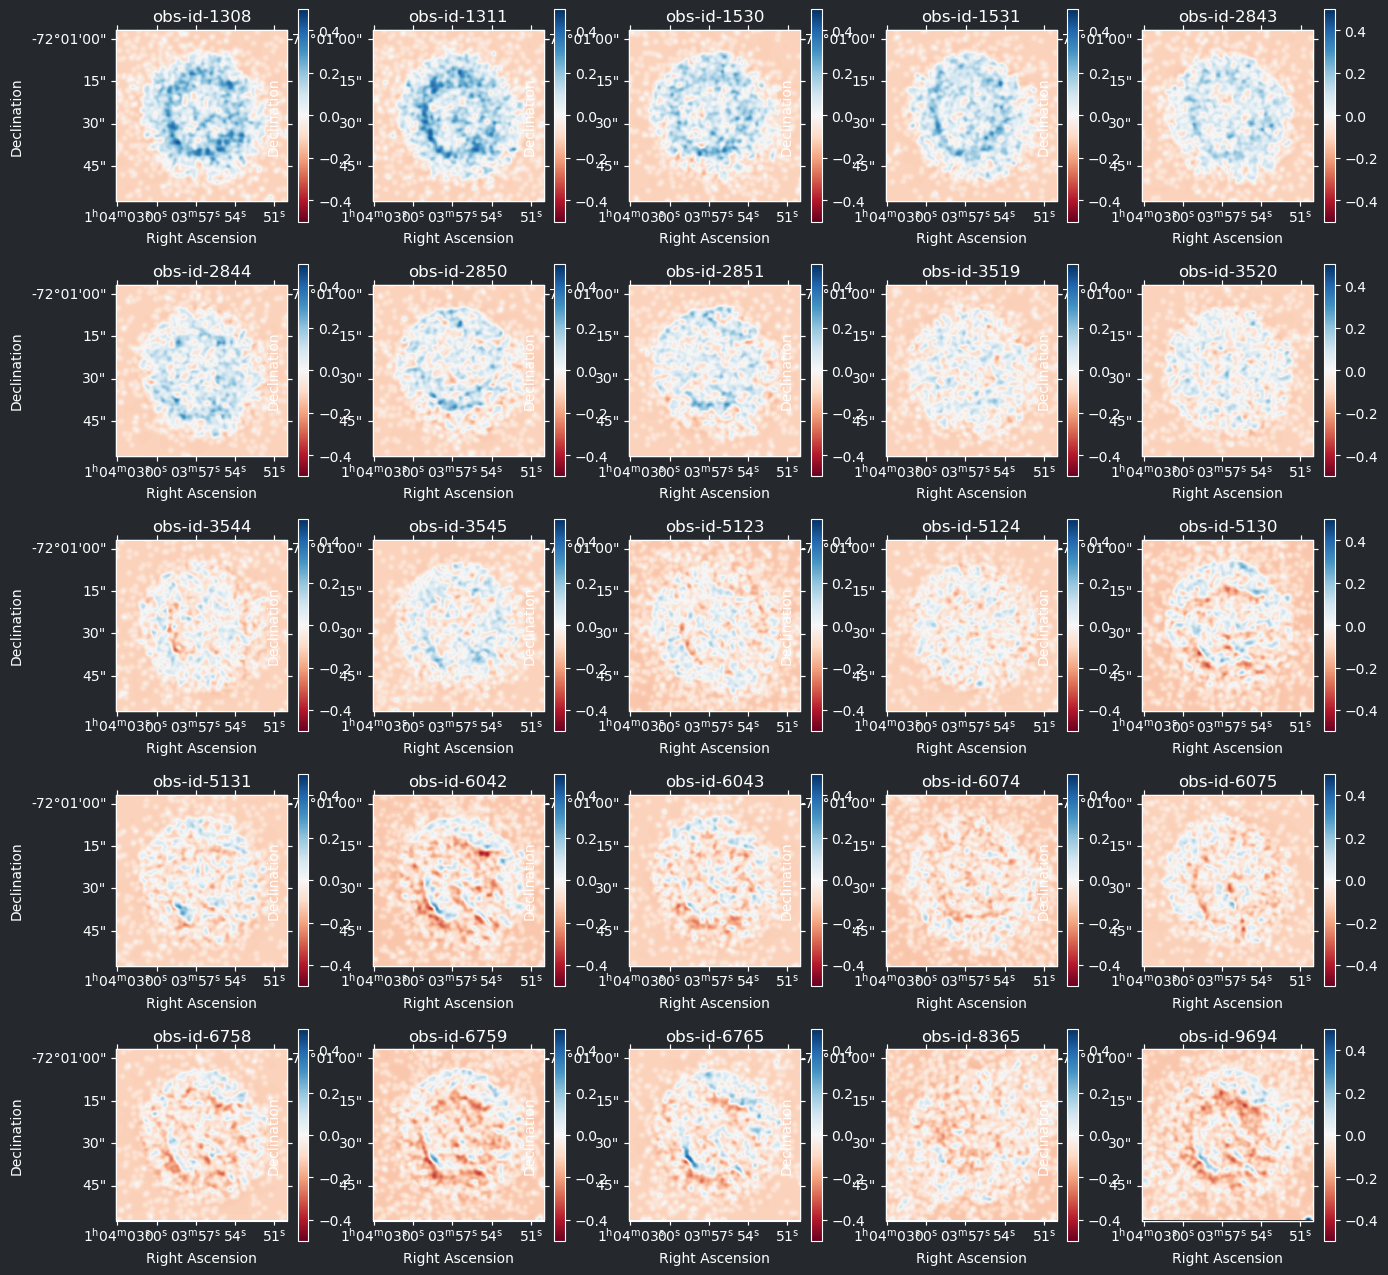

In [31]:
fig, axes = plt.subplots(
    ncols=5,
    nrows=5,
    subplot_kw={"projection": wcs},
    gridspec_kw={"wspace": 0.2},
    figsize=(16, 16)
)


for name, ax in zip_longest(sorted(datasets_jolideco), axes.flat):
    if name is None:
        ax.set_visible(False)
        continue
        
    dataset = datasets[name]
    counts = dataset["counts"].sum_over_axes(keepdims=False).smooth(5)
    npred = npreds[name].smooth(5)
    
    residual = (counts - npred) / np.sqrt(npred)
    
    residual.plot(ax=ax, vmin=-0.5, vmax=0.5, cmap="RdBu", add_cbar=True)
    ax.set_title(f"{name}")

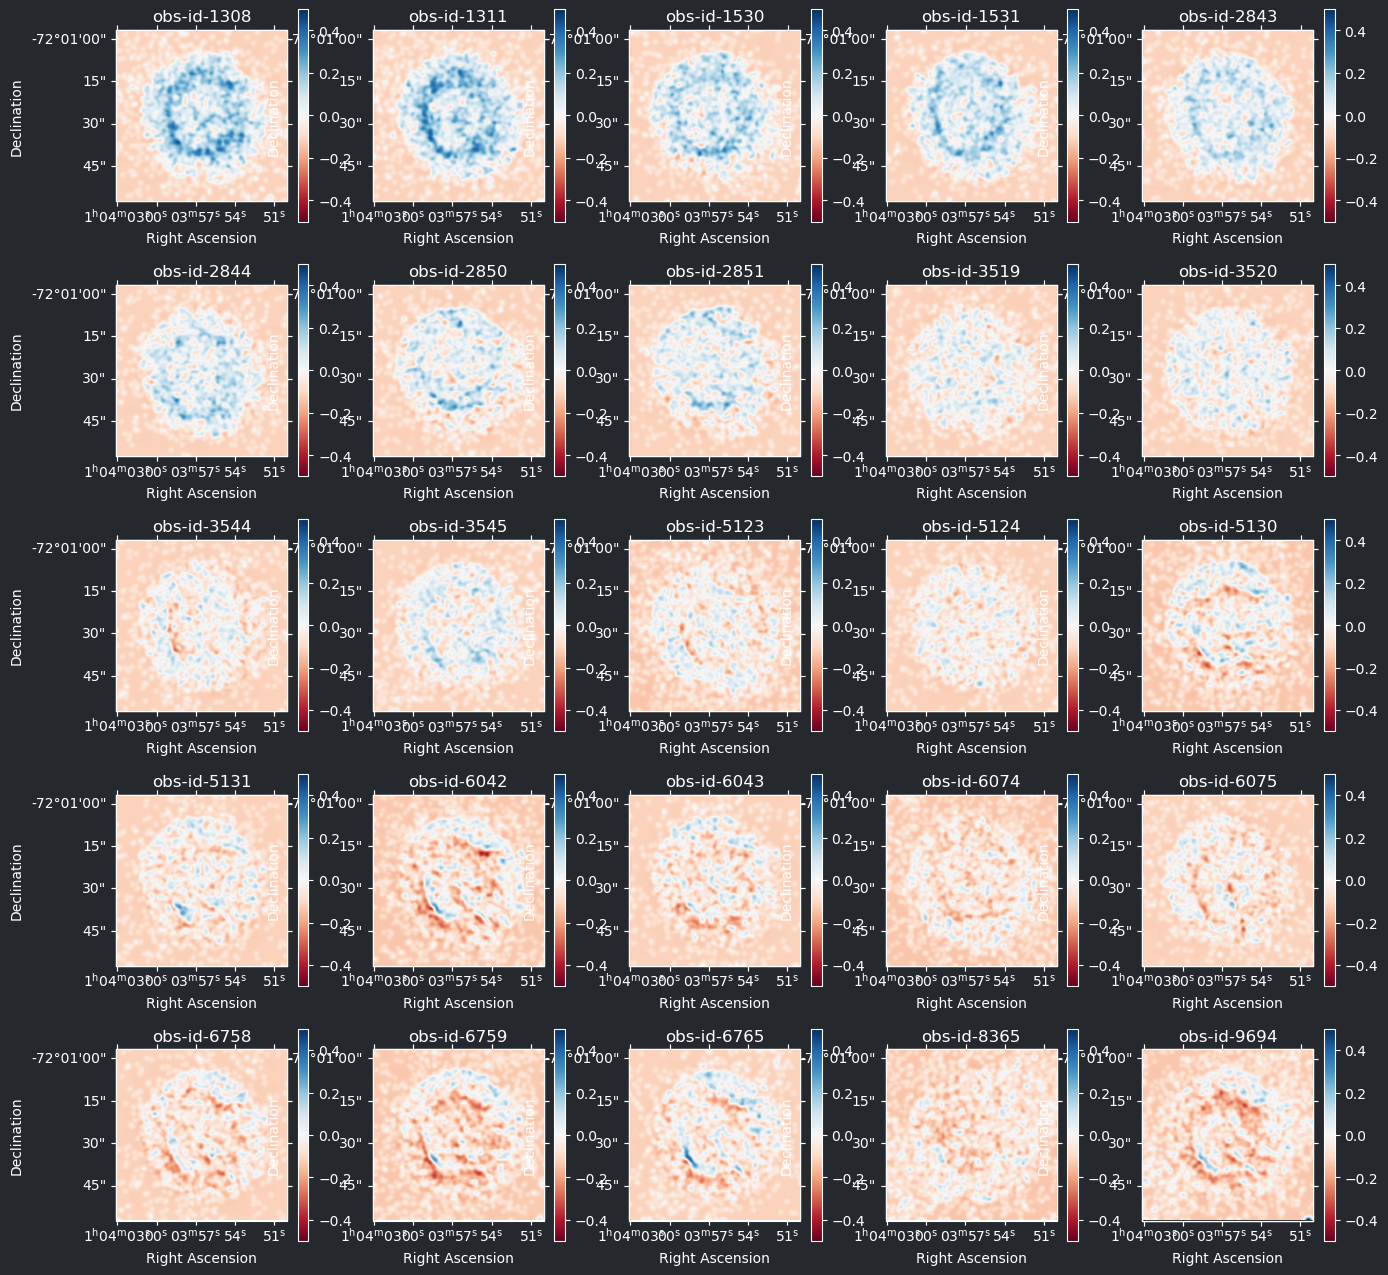

In [32]:
fig, axes = plt.subplots(
    ncols=5,
    nrows=5,
    subplot_kw={"projection": wcs},
    gridspec_kw={"wspace": 0.2},
    figsize=(16, 16)
)


for name, ax in zip_longest(sorted(datasets_jolideco), axes.flat):
    if name is None:
        ax.set_visible(False)
        continue
        
    dataset = datasets[name]
    counts = dataset["counts"].sum_over_axes(keepdims=False).smooth(5)
    npred = npreds_calibrated[name].smooth(5)
    
    residual = (counts - npred) / np.sqrt(npred)
    
    residual.plot(ax=ax, vmin=-0.5, vmax=0.5, cmap="RdBu", add_cbar=True)
    ax.set_title(f"{name}")

In [33]:
print(result.calibrations)

NPredCalibrations
-----------------

  obs-id-9694           : 

    shift_x             : -0.418
    shift_y             : -0.778
    background_norm     : 0.001
    frozen              : False

  obs-id-2843           : 

    shift_x             : -0.290
    shift_y             : 0.212
    background_norm     : 0.001
    frozen              : False

  obs-id-2844           : 

    shift_x             : 0.749
    shift_y             : 0.804
    background_norm     : 0.001
    frozen              : False

  obs-id-5124           : 

    shift_x             : 0.817
    shift_y             : 0.157
    background_norm     : 0.001
    frozen              : False

  obs-id-5123           : 

    shift_x             : 0.773
    shift_y             : 0.520
    background_norm     : 0.001
    frozen              : False

  obs-id-1311           : 

    shift_x             : -0.077
    shift_y             : -0.153
    background_norm     : 0.002
    frozen              : False

  obs-id-6765   